# Fraud Detector - Dealing with Imbalanced Datasets

In this notebook we'll use a variety of predictive models to see how accurately they can predict fraudulent vs non-fraudulent transactions.


### Goals:
- Use different classification metrics such as precison, recall and f1 to determine which classifier is best.
- Apply Random-Undersampling/SMOTE to the dataset in order to deal with the heavy class imbalance. 
- Try models that are robust to class imbalances such as Hist Gradient Boosting Classifier.

#### Understanding our data
- The description of the dataset says that all features went through a PCA (Dimensionality Reduction Technique) transformation, except for "Time" and "Amount", meaning all "V" features are already scaled (Since that is need in order to implement PCA).
- Most of the transactions (99.83%) are non-fraud, meaning only 0.17% of the transactions are classified as fraud, making the dataset heavily skewed.
- There are no null (Nan) values, making it a little easier for us to work with the data.

In [1]:
import pandas as pd

creditcard = pd.read_csv("creditcard.csv")
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
X = creditcard.drop(columns="Class")
y = creditcard["Class"]

In [3]:
print(f" No Frauds: {y.value_counts(normalize=True)[0] * 100:.2f} % of the dataset")
print(f" Frauds: {y.value_counts(normalize=True)[1] * 100:.2f} % of the dataset")

 No Frauds: 99.83 % of the dataset
 Frauds: 0.17 % of the dataset


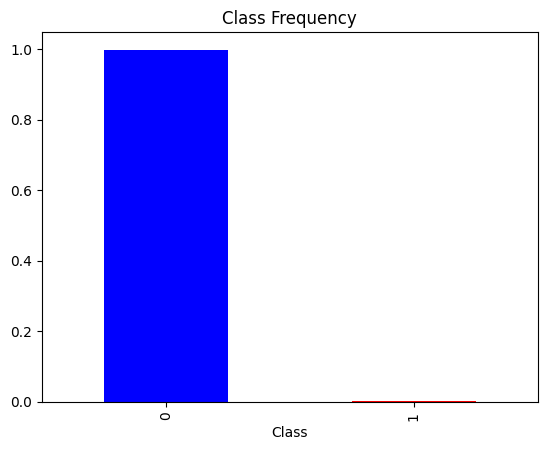

In [4]:
import matplotlib.pyplot as plt

y.value_counts(normalize=True).plot.bar(color=["blue", "red"])
plt.title("Class Frequency")
plt.show()

**Note:** Since most of the transcations are not fraudulent, if we use this dataframe as the base for our predictive models and analysis our models will probably overfit since they will "assume" that most transactions are not fraudulent.

### Scaling and Distributing

We will first scale the columns comprise of Time and Amount . Time and amount should be scaled as the other columns.

Since the original dataset is heavily imbalanced, using it will cause:
- Overfitting: Our model will assume that in most cases there are no frauds
- Wrong correlations: By having an imbalanced dataset we are not able to see the true correlations between the classes and features

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.preprocessing import RobustScaler

# Robust scaler is better for imbalanced datasets since it's less prone to outliers

scaler = RobustScaler()

# Scale 'Amount' and 'Time' in the training set
X_train["scaled_amount"] = scaler.fit_transform(X_train["Amount"].values.reshape(-1, 1))
X_train["scaled_time"] = scaler.fit_transform(X_train["Time"].values.reshape(-1, 1))

# Scale 'Amount' and 'Time' in the test set using the same scaler
X_test["scaled_amount"] = scaler.transform(X_test["Amount"].values.reshape(-1, 1))
X_test["scaled_time"] = scaler.transform(X_test["Time"].values.reshape(-1, 1))

X_train.drop(columns=["Amount", "Time"], inplace=True, axis=1)
X_test.drop(columns=["Amount", "Time"], inplace=True, axis=1)

# Rearrange columns 
scaled_amount_train = X_train.pop("scaled_amount")
scaled_time_train = X_train.pop("scaled_time")
X_train.insert(0, "scaled_amount", scaled_amount_train)
X_train.insert(1, "scaled_time", scaled_time_train)

scaled_amount_test = X_test.pop("scaled_amount")
scaled_time_test = X_test.pop("scaled_time")
X_test.insert(0, "scaled_amount", scaled_amount_test)
X_test.insert(1, "scaled_time", scaled_time_test)

# Check the results
X_train.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
223361,-0.167972,0.688774,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,...,0.167987,-0.125390,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145
165061,0.334266,0.381307,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,...,-1.692780,-0.470372,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792
238186,-0.140000,0.761745,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,...,0.198772,0.012227,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288
150562,1.334825,0.105269,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,...,-2.147124,-0.253757,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931
138452,0.052587,-0.024100,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,...,0.712695,-0.012320,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672


### Random-Undersampling
In Random-Undersampling we remove data in order to have a more balanced dataset, thus hopefully preventing our models from overfitting. The main issue with this is that our model might not be as accurate since we're losing a considerable amount of data(from 284,315 non-fraud to 492 non-fraud)


#### Steps
1 - Determine the amount of fraudulent transactions in our dataset:

In [7]:
y.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

2 - Bring the amount of fraud and non-fraud transactions close to a 50/50 ratio by reducing the amount of fraud transcations to 492:
- Before we do this is very important to know that we should **not** undersample or oversample data before cross-validation. This will cause a "data leakage" problem, where the synthetic data will affect the validation set, which should not be touched!

3 - Try Logistic Regression and SVC classifiers to see which gives us a better score.
    We can then shuffle the data to see if our models can mantain a certain accuracy everytime we run this script

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Statrified cross validation strategy to keep the class balance
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr = LogisticRegression(max_iter=1500)
svc = SVC()

param_grid = {
    "C": [0.01, 0.1, 1, 10, 100, 1000],
}
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

grid_search = GridSearchCV(lr, param_grid=param_grid, cv=skf)
grid_svc = GridSearchCV(SVC(), svc_params)

In [9]:
from sklearn.metrics import classification_report

best_f1_score = 0

# Split the data into training and validation sets
for train_idx, val_idx in skf.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # combine features for the training set
    train_df = pd.concat([X_fold_train, y_fold_train], axis=1)

    # Get fraud and non-fraud samples
    fraud_df = train_df[train_df["Class"]== 1]
    non_fraud_df = train_df[train_df["Class"]== 0].sample(n=len(fraud_df), random_state=42)

    # concatenate samples into df
    balanced_df = pd.concat([fraud_df, non_fraud_df])
    balanced_df = balanced_df.sample(frac=1, random_state=42)

    # Split into features and target
    X_train_balanced = balanced_df.drop("Class", axis=1)
    y_train_balanced = balanced_df["Class"]  

    grid_search.fit(X_train_balanced, y_train_balanced)
    grid_svc.fit(X_train_balanced, y_train_balanced)

    y_cv_pred = grid_search.predict(X_fold_val)
    y_cv_svc = grid_svc.predict(X_fold_val)

    report_lr = classification_report(y_fold_val, y_cv_pred, output_dict=True)
    report_svc = classification_report(y_fold_val, y_cv_svc, output_dict=True)
    
    best_lr = report_lr["weighted avg"]["f1-score"]
    best_svc = report_svc["weighted avg"]["f1-score"]

    # Select the best model based on F1 score
    if best_lr > best_f1_score:
        best_f1_score = best_lr
        best_model = ("Logistic Regression", grid_search, y_cv_pred, y_fold_val)

    if best_svc > best_f1_score:
        best_f1_score = best_svc
        best_model = ("SVC", grid_svc, y_cv_svc, y_fold_val)

model_name, model, best_y_pred, best_y_true = best_model
print(f"Best Model: {model_name}")
print(f"Best Params: {model.best_estimator_}")
print(f"Classification Report:\n {classification_report(best_y_true, best_y_pred)}")

Best Model: Logistic Regression
Best Params: LogisticRegression(C=0.1, max_iter=1500)
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     45490
           1       0.12      0.87      0.21        79

    accuracy                           0.99     45569
   macro avg       0.56      0.93      0.60     45569
weighted avg       1.00      0.99      0.99     45569



In [10]:
y_train_balanced.value_counts()

Class
0    315
1    315
Name: count, dtype: int64

As we can see we're not able to bring the samples exactly to 492/492. That is because StratifiedKFold ensures class distribution, each fold contains only a subset of the training data, which reduces the number of samples available for the minority class.
With 5 fold corss-validation, each fold uses 80% for training and 20% for validation. In each training fold we get aproximately 492 * 0.8 = ~394. However our actual number becomes 315 due to stratification.

<Axes: title={'center': 'Balanced Class Distribution'}, xlabel='Class'>

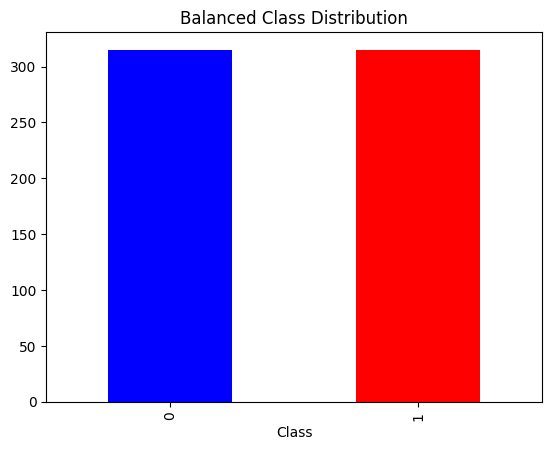

In [11]:
y_train_balanced.value_counts().plot.bar(color=["blue", "red"], title="Balanced Class Distribution")

Since our dataset is imbalanced and we're testing on a still imbalanced validation set, accuracy and weighted F1-score are misleading.

### Precision-Recall and ROC-AUC Curves

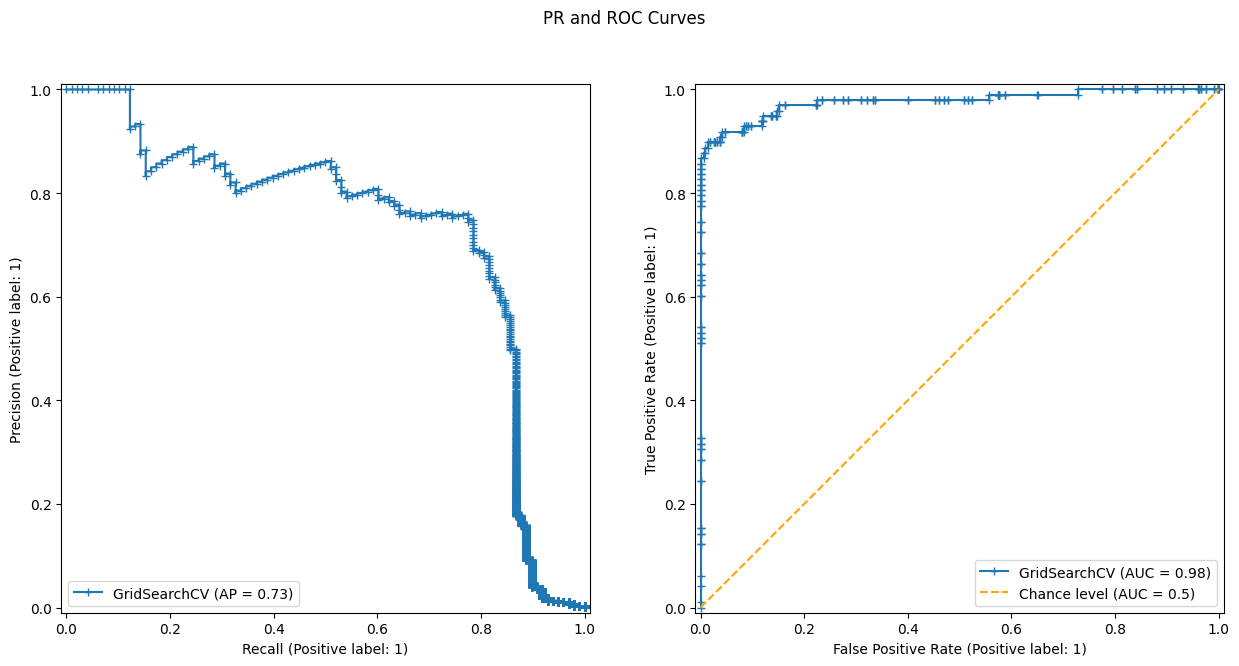

In [15]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as ply

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,7))

PrecisionRecallDisplay.from_estimator(
    model,
    X_test,
    y_test,
    pos_label=1,
    marker="+",
    ax=ax[0]
)

RocCurveDisplay.from_estimator(
    model,
    X_test,
    y_test,
    pos_label=1,
    marker="+",
    plot_chance_level=True,
    chance_level_kw={"color": "orange", "linestyle": "--"},
    ax=ax[1]
)

_ = fig.suptitle("PR and ROC Curves")

- With 45490 samples of class 0 (non fraud) and only 79 samples of class 1 (fraud) in our test set, the ROC AUC is heavily influenced by the majority class. Even if our model predicts very few frauds (class 1), it can still achieve a high true positive rate and a low false positive rate, leading to an inflated AUC-ROC(0.98).
- A model that predicts the majority class most of the time can still achieve a high AUC-ROC score because the true negative rate (correctly classifying non-fraudulent transactions) is very high
- The PR score of 0.73 indicates that while our model has reasonable precision and recall for the minority class, it’s not as stellar as the AUC-ROC suggests. Precision drops because, even though recall is high, our model predicts a lot of false positives, which reduces the trustworthiness of fraud predictions.

### Confusion Matrix

- True Negatives (Top Left): Transactions that were not fraud and our model predicted as such
- False Negatives (Top Right): Transactions that were fraud but were predicted as not fraud
- False Positives (Bottom Left): Transactions that were not fraud but were predicted as fraud
- True Postivies (Bottom Right): Transactions that were fraud and our model predicted as such

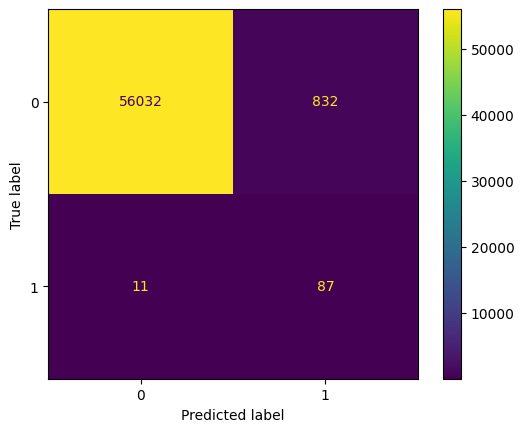

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.show()


### SMOTE(Synthetic Minority Over-sampling Technique)

SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems".


Understanding SMOTE:

- Solving the Class Imbalance: SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.
- Location of the synthetic points: SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.
- Final Effect: More information is retained since we didn't have to delete any rows unlike in random undersampling.
- Accuracy - Time Tradeoff: Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_validate
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, average_precision_score

scorer = make_scorer(average_precision_score, pos_label=1)

classifier = LogisticRegression()

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_distributions = {
    "C": [0.01, 0.1, 1, 10, 100, 1000],
    "max_iter": [500, 1000, 1500, 2000] 
}

# Nested CV
random_search = RandomizedSearchCV(classifier, param_distributions=param_distributions, cv=inner_cv)
model = make_pipeline(SMOTE(sampling_strategy='minority'), random_search)

cv_results = cross_validate(model, X_train, y_train, cv=outer_cv, n_jobs=2, scoring=scorer, return_estimator=True, return_train_score=True)

In [20]:
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,estimator,test_score,train_score
0,25.742571,0.007578,"(SMOTE(sampling_strategy='minority'), Randomiz...",0.054375,0.055243
1,21.393570,0.008418,"(SMOTE(sampling_strategy='minority'), Randomiz...",0.052985,0.055551
2,19.700996,0.005593,"(SMOTE(sampling_strategy='minority'), Randomiz...",0.053073,0.051537
3,20.229200,0.005143,"(SMOTE(sampling_strategy='minority'), Randomiz...",0.051331,0.055268
4,15.784721,0.006034,"(SMOTE(sampling_strategy='minority'), Randomiz...",0.053989,0.059838


By comparing the train and test scores, we can see that our model is not overfitting to the synthetic samples created by SMOTE

In [21]:
import numpy as np

best_fold_idx = np.argmax(cv_results["test_score"])
best_fold = cv_results["estimator"][best_fold_idx]

labels = ['No Fraud', 'Fraud']
smote_prediction = best_fold.predict(X_test)
print(classification_report(y_test, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56864
       Fraud       0.11      0.89      0.20        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.60     56962
weighted avg       1.00      0.99      0.99     56962



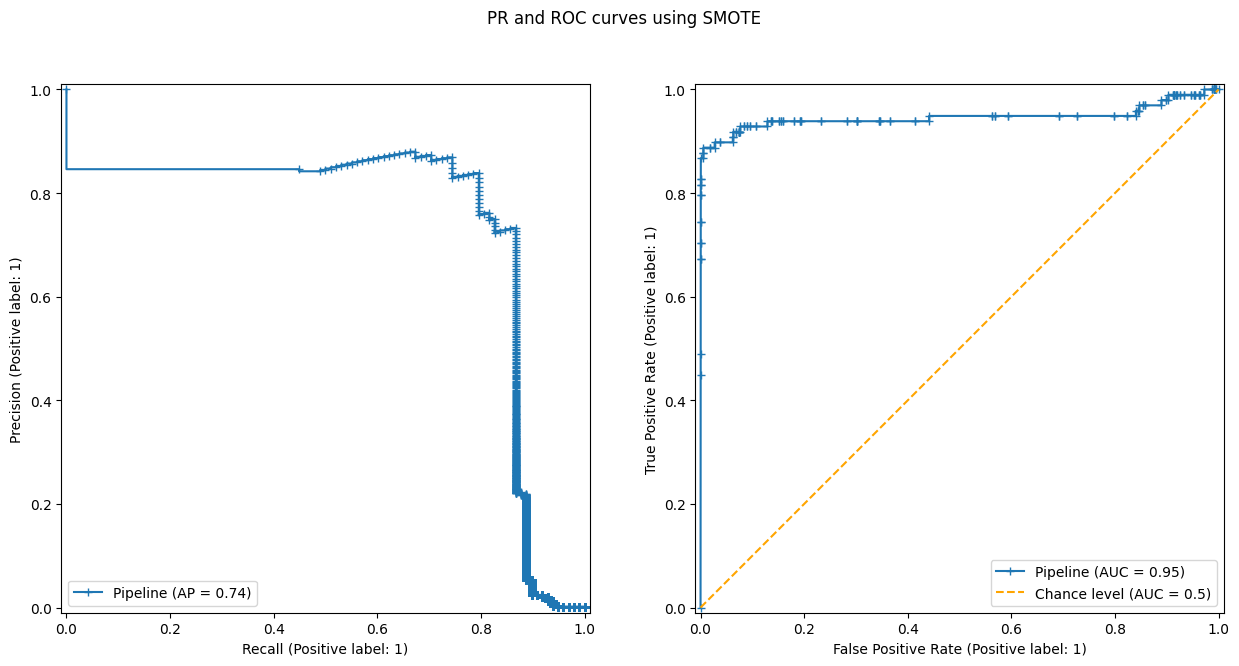

In [23]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.dummy import DummyClassifier

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))

PrecisionRecallDisplay.from_estimator(
    best_fold, 
    X_test,
    y_test, 
    pos_label=1,
    marker="+",
    ax =ax[0]
)

RocCurveDisplay.from_estimator(
    best_fold, 
    X_test,
    y_test, 
    pos_label=1,
    marker="+",
    plot_chance_level=True,
    chance_level_kw={"color": "orange", "linestyle": "--"},
    ax =ax[1]
)

plt.suptitle("PR and ROC curves using SMOTE")

plt.show()

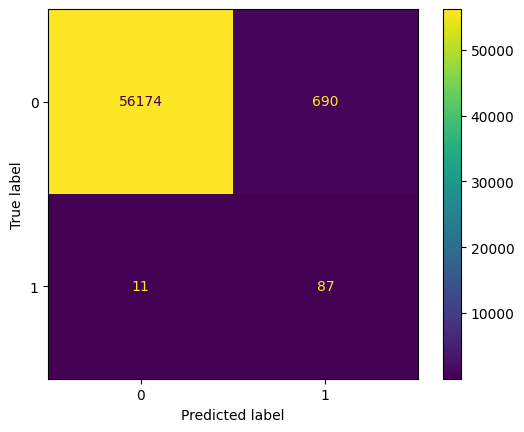

In [26]:
ConfusionMatrixDisplay.from_estimator(best_fold, X_test, y_test)
plt.show()

After implementing both Undersampling and SMOTE we can see that our model using undersampling misclassified 832 fraud transactions as not fraud, while our model with SMOTE only misclassified 690 of them, leading to the conclusion that the SMOTE model is indeed a better choice in this case.

### Histogram Gradient Boosting Classifier
A HistGradientBoostingClassifier can often outperform simpler models, like Logistic Regression, in fraud detection tasks with heavily imbalanced classes because it has several features and properties that make it naturally suited for such data:
- Boosting gives higher weights to erros(minority class) improving performance
- Tree based models handle non-linear relationships naturally, which are common fraud datasets
- Tree based models are also robust to outliers since outliers in continuous features are binned into histogram bins.
- Trees can split data in ways that isolate outliers without affecting the majority class
- Bins continous features improving speed, memory usage and captures meaningful splits even when classes are heavily imbalanced
- Feature scaling is not needed with tree based models since they look at features independently
- Boosted models like HistGradientBoostingClassifier tend to provide better PR AUC because they optimize for the harder-to-classify minority class.


In [28]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

outer_cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

boost = HistGradientBoostingClassifier(max_iter = 1_000, early_stopping=True, random_state=42)

param_distributions = {
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
    "class_weight": ["balanced", None],
    "max_bins": [16, 32, 64, 128], 
    "min_samples_leaf": [1, 5, 10, 20],
    "l2_regularization": loguniform(1e-3, 10)   
}

random_search = RandomizedSearchCV(boost, n_iter=10, param_distributions=param_distributions, cv=inner_cv, scoring="average_precision")
boost_results = cross_validate(random_search, X_train, y_train, cv=outer_cv, return_estimator=True)

In [29]:
for fold, est in enumerate(boost_results["estimator"]):
    print(f"best param for fold # {fold + 1}: {est.best_params_}")

best param for fold # 1: {'class_weight': None, 'l2_regularization': np.float64(0.01343774306854147), 'learning_rate': np.float64(0.020710233268157473), 'max_bins': 128, 'max_leaf_nodes': 100, 'min_samples_leaf': 5}
best param for fold # 2: {'class_weight': None, 'l2_regularization': np.float64(0.12253283942809005), 'learning_rate': np.float64(0.015899193268189504), 'max_bins': 64, 'max_leaf_nodes': 10, 'min_samples_leaf': 1}
best param for fold # 3: {'class_weight': None, 'l2_regularization': np.float64(0.0038608589184219496), 'learning_rate': np.float64(0.012838217550235499), 'max_bins': 16, 'max_leaf_nodes': 20, 'min_samples_leaf': 5}
best param for fold # 4: {'class_weight': None, 'l2_regularization': np.float64(2.4520749791269245), 'learning_rate': np.float64(0.1685973232712877), 'max_bins': 128, 'max_leaf_nodes': 100, 'min_samples_leaf': 10}
best param for fold # 5: {'class_weight': None, 'l2_regularization': np.float64(0.09694396506921048), 'learning_rate': np.float64(0.07140871

In [30]:
best_fold_idx = boost_results["test_score"].argmax()
best_fold_params = boost_results["estimator"][best_fold_idx].best_params_
print(f"\nBest fold params:")
print(best_fold_params)


Best fold params:
{'class_weight': None, 'l2_regularization': np.float64(0.01343774306854147), 'learning_rate': np.float64(0.020710233268157473), 'max_bins': 128, 'max_leaf_nodes': 100, 'min_samples_leaf': 5}


In [31]:
best_model = boost_results["estimator"][best_fold_idx]
y_pred_boost = best_model.predict(X_test)
y_pred_proba_boost = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_boost, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56864
       Fraud       0.95      0.70      0.81        98

    accuracy                           1.00     56962
   macro avg       0.97      0.85      0.90     56962
weighted avg       1.00      1.00      1.00     56962



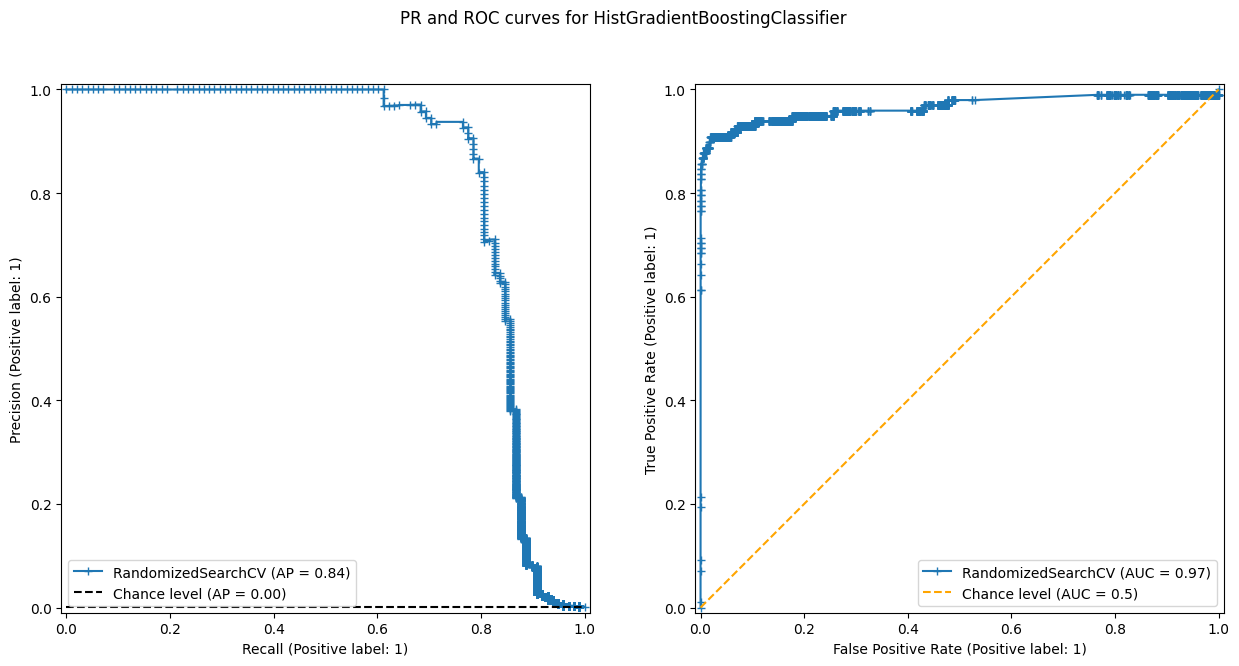

In [41]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))

PrecisionRecallDisplay.from_estimator(
    best_model, 
    X_test,
    y_test, 
    pos_label=1,
    marker="+",
    ax =ax[0],
    plot_chance_level=True
)

RocCurveDisplay.from_estimator(
    best_model, 
    X_test,
    y_test, 
    pos_label=1,
    marker="+",
    plot_chance_level=True,
    chance_level_kw={"color": "orange", "linestyle": "--"},
    ax =ax[1]
)

plt.suptitle("PR and ROC curves for HistGradientBoostingClassifier")

plt.show()

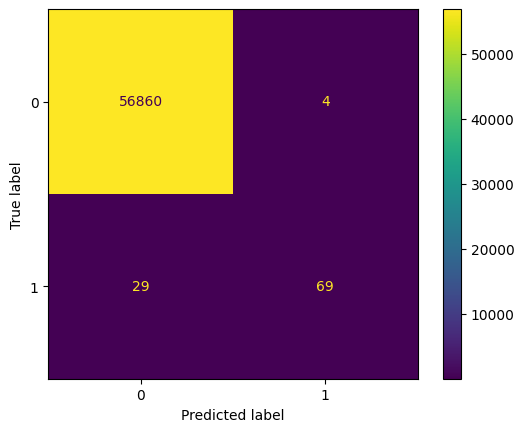

In [37]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

As we can see our HistGradientBoostingClassifier is a much better model compared to our LogisticRegression Classifier using SMOTE.
We can try to further tune our models threshold in order to achieve a better precision/recall scores:

In [34]:
actual_threshold = min(y_pred_proba_boost[y_pred_boost == 1])

print(f"Model's classification threshold: {actual_threshold:.4f}")

Model's classification threshold: 0.5402


In [39]:
from sklearn.metrics import precision_recall_curve

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7] 

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba_boost >= threshold).astype(int)
    
    print(f"\nResults with threshold = {threshold}")
    print(classification_report(y_test, y_pred_threshold))

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_boost)

target_recall = 0.8

closest_idx = np.argmin(np.abs(recalls - target_recall))
optimal_threshold = thresholds[closest_idx]

print(f"\nTo achieve approximately {target_recall:.2f} recall, use threshold = {optimal_threshold:.3f}")
y_pred_optimal = (y_pred_proba_boost >= optimal_threshold).astype(int)
print("\nResults with optimal threshold:")
print(classification_report(y_test, y_pred_optimal, target_names=labels))


Results with threshold = 0.3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.70      0.80        98

    accuracy                           1.00     56962
   macro avg       0.97      0.85      0.90     56962
weighted avg       1.00      1.00      1.00     56962


Results with threshold = 0.4
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.70      0.81        98

    accuracy                           1.00     56962
   macro avg       0.97      0.85      0.90     56962
weighted avg       1.00      1.00      1.00     56962


Results with threshold = 0.5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.70      0.81        98

    accuracy                           1.00     56962
   macro avg       0.97      0.85     